# Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import math
import pickle
import os
from IPython.display import display

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import squarify
from sklearn.preprocessing import MinMaxScaler
from math import pi

# Dates
import datetime as dt
from datetime import timedelta

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

# PCA
from sklearn.decomposition import PCA
from matplotlib.patches import Circle

import warnings
warnings.simplefilter(action = 'ignore')

# Sommaire
#!pip install jyquickhelper
#from jyquickhelper import add_notebook_menu # attention, ne prend que les titres de niveau 2
#add_notebook_menu()

In [2]:
# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Import des données

## Import

In [3]:
# import des données

# Chemin d'accès aux données (à modifier si code en local)
#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

filepath = os.path.join(path, 'df')

with open(filepath, 'rb') as f:
    df_final = pickle.load(f)

df_final.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_installments,payment_value,review_score,review_time,order_time,delivery_error_time,order_preparation_time,shipping_limit_respect,review,distance,product_nb,customer_city,customer_state,order_status,payment_type,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,product_category_,product_category_Electronics and Technology,product_category_Fashion and Accessories,product_category_Furniture and Home Decor,product_category_Leisure and Miscellaneous
0,1.06303,-0.70040,-0.11360,0.05134,-0.13044,-0.70900,-0.09601,0.68586,-0.22248,1.36738,0.78108,0.75614,-0.53095,-0.33171,0.20950,0.46681,0,0,1,1,2017.0,11.0,3.0,30.0,21.0,0,0,0,1,0
1,-0.61370,0.29287,-0.11360,-0.29139,-0.13044,-0.70900,-0.55278,-0.92014,0.04272,0.14300,-0.11657,0.98629,-0.75761,-0.33171,0.02066,-0.36326,0,0,1,1,2017.0,10.0,6.0,29.0,18.0,0,0,0,0,1
2,0.32946,-0.37099,-0.73142,-0.56494,-0.13044,0.08583,-0.65354,0.68586,-0.03875,-0.39753,-3.23460,0.08886,1.01142,2.65422,-0.07102,-0.36326,0,0,1,1,2018.0,5.0,0.0,7.0,0.0,0,0,0,0,1
3,-2.39522,1.18867,-0.73142,-0.23414,-0.13044,2.07291,-0.06261,-0.11714,0.20993,-1.02482,-0.67837,-0.62902,0.54607,-0.33171,-0.10380,-0.36326,0,0,1,1,2017.0,8.0,6.0,27.0,21.0,0,1,0,0,0
4,0.43426,2.93488,-0.73142,-0.60470,-0.13044,-0.70900,-0.72670,0.68586,-0.28311,-0.04300,-1.96742,0.77196,-1.19216,-0.33171,-1.11828,-0.36326,0,0,1,1,2017.0,1.0,3.0,5.0,13.0,0,1,0,0,0


In [4]:
df_final.shape

(87099, 30)

# Jeu de données réduit

## Choix variables

In [5]:
# on reprend le df

df_final.columns

Index(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score', 'review_time',
       'order_time', 'delivery_error_time', 'order_preparation_time',
       'shipping_limit_respect', 'review', 'distance', 'product_nb',
       'customer_city', 'customer_state', 'order_status', 'payment_type',
       'purchase_year', 'purchase_month', 'purchase_dayofweek', 'purchase_day',
       'purchase_hour', 'product_category_',
       'product_category_Electronics and Technology',
       'product_category_Fashion and Accessories',
       'product_category_Furniture and Home Decor',
       'product_category_Leisure and Miscellaneous'],
      dtype='object')

In [6]:
df_final.reset_index(drop = True, inplace = True)

In [7]:
# reconstituer date

from datetime import datetime
df_final['Date_achat'] = df_final.apply(lambda row: datetime.strptime(f"{int(row.purchase_year)}-{int(row.purchase_month)}-{int(row.purchase_day)}", '%Y-%m-%d'), axis=1)
#df_final['Date_achat'] = pd.to_datetime(df_final[['purchase_year', 'purchase_month', 'purchase_day']])
df_final['Date_achat']

0       2017-11-30
1       2017-10-29
2       2018-05-07
3       2017-08-27
4       2017-01-05
           ...    
87094   2018-04-30
87095   2017-12-15
87096   2018-05-07
87097   2017-06-15
87098   2017-05-03
Name: Date_achat, Length: 87099, dtype: datetime64[ns]

In [8]:
# Choix d'après résultats ACP :

df_reduit = df_final[[
    'product_nb', # nombre de produits achetés
    #'product_name_lenght',
    'product_description_lenght',
    #'product_photos_qty',
    'product_weight_g',
    'payment_sequential', # nb de types de paiement
    'payment_installments', # paiement en plusieurs fois
    'payment_value',
    #'review_score',
    #'review_time',
    #'order_time',
    #'delivery_error_time',
    #'order_preparation_time',
    #'shipping_limit_respect',
    #'purchase_month',
    #'purchase_dayofweek',
    #'purchase_day',
    #'purchase_hour',
    'review',
    #'distance'
    ]]

In [9]:
df_reduit.columns

Index(['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value',
       'review'],
      dtype='object')

In [10]:
df_reduit.reset_index(drop = True, inplace = True)

In [11]:
df_reduit

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review
0,0.46681,-0.70040,0.05134,-0.13044,-0.70900,-0.09601,-0.33171
1,-0.36326,0.29287,-0.29139,-0.13044,-0.70900,-0.55278,-0.33171
2,-0.36326,-0.37099,-0.56494,-0.13044,0.08583,-0.65354,2.65422
3,-0.36326,1.18867,-0.23414,-0.13044,2.07291,-0.06261,-0.33171
4,-0.36326,2.93488,-0.60470,-0.13044,-0.70900,-0.72670,-0.33171
...,...,...,...,...,...,...,...
87094,2.95703,-0.31721,0.30977,-0.13044,-0.31159,1.26897,5.64015
87095,-0.36326,-1.17267,0.46881,-0.13044,-0.31159,-0.60127,-0.33171
87096,-0.36326,-1.07183,-0.38602,-0.13044,-0.31159,-0.57028,2.65422
87097,-0.36326,-0.72057,-0.45719,-0.13044,0.88066,1.40077,-0.33171


## Kmeans

### K optimal

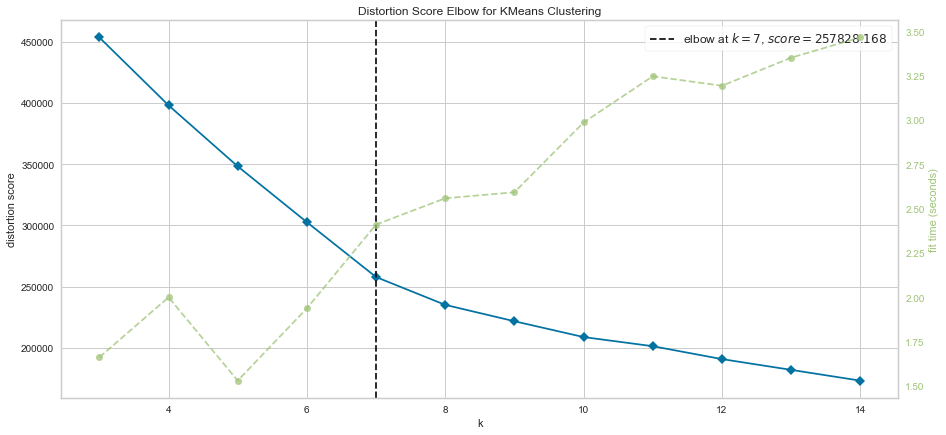

CPU times: user 2min 34s, sys: 1min 7s, total: 3min 41s
Wall time: 31.6 s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
%%time

# KElbowVisualizer - 'distortion' metric (default metric)
# Instantiate the clustering model and visualizer
model = KMeans()
d_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'distortion'
    )

# Fit the data to the visualizer
d_visualizer.fit(df_reduit)

# Finalize and render the figure
d_visualizer.show()

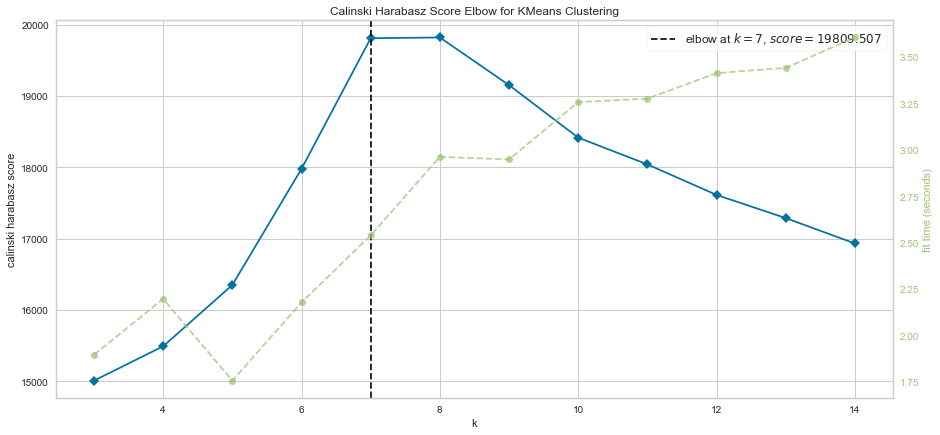

CPU times: user 2min 39s, sys: 1min 25s, total: 4min 4s
Wall time: 33.8 s


<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [13]:
%%time

# KElbowVisualizer - 'calinski_harabasz' metric
# Instantiate the clustering model and visualizer
model = KMeans()
ch_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'calinski_harabasz'
    )

# Fit the data to the visualizer
ch_visualizer.fit(df_reduit)

# Finalize and render the figure
ch_visualizer.show()   

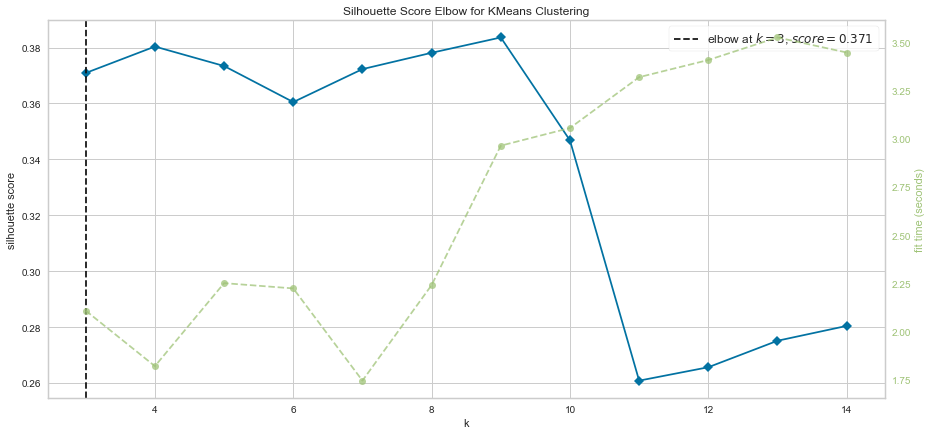

CPU times: user 31min 24s, sys: 12min 6s, total: 43min 31s
Wall time: 12min 23s


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [14]:
%%time

# KElbowVisualizer - 'silhouette' metric
# Instantiate the clustering model and visualizer
model = KMeans()
s_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'silhouette'
    )

# Fit the data to the visualizer
s_visualizer.fit(df_reduit)

# Finalize and render the figure
s_visualizer.show()

In [481]:
"""%%time

# Elbow method with differents metrics (subplots)
metrics = ['distortion', 'silhouette', 'calinski_harabasz']
i = 0

fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex = False, sharey = False, figsize = (24, 8))
for m in metrics:
    model = KMeans()
    kmeans_visualizer = KElbowVisualizer(
        model,
        k = (3, 15),
        size = (1080, 500),
        metric = m
        )
    kmeans_visualizer.fit(df_reduit)
    i+=1

plt.show()"""

"%%time\n\n# Elbow method with differents metrics (subplots)\nmetrics = ['distortion', 'silhouette', 'calinski_harabasz']\ni = 0\n\nfig, axes = plt.subplots(nrows = 1, ncols = 3, sharex = False, sharey = False, figsize = (24, 8))\nfor m in metrics:\n    model = KMeans()\n    kmeans_visualizer = KElbowVisualizer(model, \n                              k = (3, 15), \n                              size = (1080, 500), \n                              metric = m)\n    kmeans_visualizer.fit(df_reduit)\n    i+=1\n\nplt.show()"

In [15]:
# Comparer le k optimal des différentes métriques :

# distortion 
k_distortion = d_visualizer.elbow_value_
print(f'Nombre optimal de clusters - distortion metric : k = {k_distortion}')

# calinski harabasz
k_calinski_harabasz = ch_visualizer.elbow_value_
print(f'Nombre optimal de clusters - calinski harabasz metric : k = {k_calinski_harabasz}')

# silhouette
k_silhouette = s_visualizer.elbow_value_
print(f'Nombre optimal de clusters - silhouette metric : k = {k_silhouette}')

Nombre optimal de clusters - distortion metric : k = 7
Nombre optimal de clusters - calinski harabasz metric : k = 7
Nombre optimal de clusters - silhouette metric : k = 3


In [483]:
stop

NameError: name 'stop' is not defined

In [12]:
k = 3
# trouver k avec une des méthodes (ne pas le sortir du chapeau)

### Clustering

In [13]:
%%time

# Instantiate the clustering model
model = KMeans(
    n_clusters = k # nb de clusters qu'on veut avoir
    #n_init = 10, # nb d'initialisations qu'on veut faire - 10 = valeur par défaut
    # #max_iter = 300, # nb d'itérations max - par défaut 300
    # #init = 'k-means++'' # quelle stratégie d'initialisation on utilise
    )

# K-Means++ -> méthode d'initialisation qui consiste à placer les centroïdes sur des points du dataset éloignés les uns des autres - facilite convergence

# Entrainer le modèle
model.fit(df_reduit)
# model.labels_ ou
model.predict(df_reduit)
centroids = model.cluster_centers_

CPU times: user 5.75 s, sys: 690 ms, total: 6.44 s
Wall time: 970 ms


In [486]:
### Evaluation du clustering :

In [14]:
# Evaluation du clustering : silhouette score
silhouette_kmeans = round(silhouette_score(df_reduit, model.fit_predict(df_reduit)), 2)
print('The average silhouette score is:', silhouette_kmeans)

The average silhouette score is: 0.37


In [ ]:
# A score closer to 1 indicates that the clustering is good, while a score closer to -1 indicates that the clustering is bad.
# Ici score de 0,16, pas dingue... voir si on arrive à l'améliorer

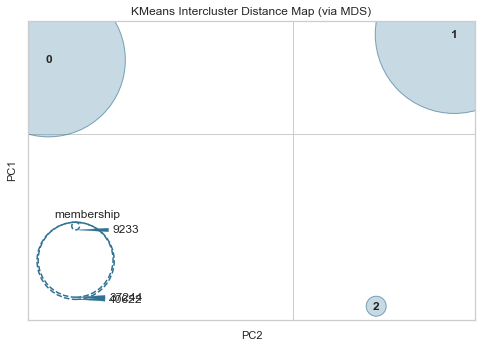

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
# Intercluster distance Map with best k

distance_visualizer = InterclusterDistance(KMeans(k))
distance_visualizer.fit(df_reduit)
distance_visualizer.show()

In [ ]:
# 3 clusters bien distincts

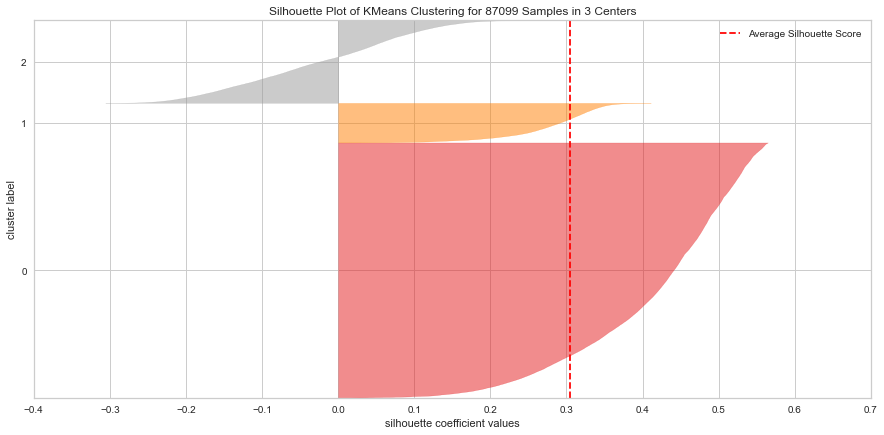

CPU times: user 5min, sys: 2min 9s, total: 7min 10s
Wall time: 2min 3s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 87099 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
%%time

# Instantiate the clustering model and visualizer
kmeans1 = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
visualizer = SilhouetteVisualizer(kmeans1, size = (1080, 500))

# Fit the data to the visualizer
visualizer.fit(df_reduit)

# Finalize and render the figure
visualizer.show()

In [ ]:
# un cluster bien plus gros que les autres -> surement possible de le diviser si on améliore le clustering

### Description des clusters

In [15]:
# Créer une copie du df pour ajouter les clusters
df_clusters = df_reduit

In [16]:
# Description des clusters obtenus

labels = model.labels_
df_clusters['cluster_num'] = labels
df_clusters.head()

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
0,0.46681,-0.70040,0.05134,-0.13044,-0.70900,-0.09601,-0.33171,2
1,-0.36326,0.29287,-0.29139,-0.13044,-0.70900,-0.55278,-0.33171,2
2,-0.36326,-0.37099,-0.56494,-0.13044,0.08583,-0.65354,2.65422,1
3,-0.36326,1.18867,-0.23414,-0.13044,2.07291,-0.06261,-0.33171,0
4,-0.36326,2.93488,-0.60470,-0.13044,-0.70900,-0.72670,-0.33171,2


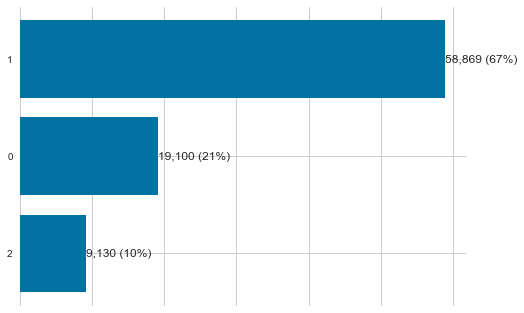

In [ ]:
# count the number of customers in each segment
segments_counts = df_clusters['cluster_num'].value_counts().sort_values(ascending = True)

fig, ax = plt.subplots()

bars = ax.barh(
        range(len(segments_counts)),
        segments_counts,
        #color = 'silver'
        )
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )

plt.show()

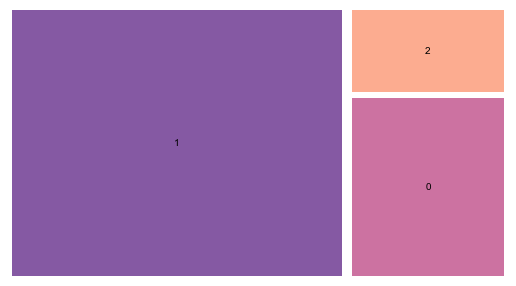

In [ ]:
#### Plotter volume de chaque clusters

# Isoler valeurs et labels des clusters
values = df_clusters['cluster_num'].value_counts().values
labels = df_clusters['cluster_num'].value_counts().index

# Squarify plot
plt.figure(figsize = (9, 5))
squarify.plot(values,
              label = labels,
              text_kwargs = {'fontsize': 10, 'color': 'black'},
              pad = 0.20,
              color = sns.color_palette('magma', len(values)),
              alpha = 0.7)
plt.axis('off')
plt.show()

In [ ]:
# Faire la moyenne pour expliquer les clusters
df_clusters.groupby('cluster_num').mean().reset_index(drop = True)

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,purchase_dayofweek,review
0,0.39184,0.09559,0.85855,-0.10679,1.16721,0.80723,0.02947,-0.31999
1,-0.16903,-0.02867,-0.26071,0.04564,-0.37426,-0.28565,-0.00680,-0.33171
2,0.27016,-0.01513,-0.11506,-0.07087,-0.02865,0.15310,-0.01784,2.80826


In [ ]:
df_clusters.columns

Index(['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value',
       'purchase_dayofweek', 'review', 'cluster_num'],
      dtype='object')

In [ ]:
# Moyenne ne correspond pas vraiment à toutes les features... adapter la méthode d'aggrégation selon les features
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.mode.html
"""
df_clusters.groupby('cluster_num').agg({
    'product_category_Electronics and Technology' : lambda x: pd.Series.mode(x)[0][0],
    'product_category_Fashion and Accessories' : lambda x: pd.Series.mode(x)[0][0],
    'product_category_Furniture and Home Decor' : lambda x: pd.Series.mode(x)[0][0],
    'product_category_Leisure and Miscellaneous' : lambda x: pd.Series.mode(x)[0][0], 
    'payment_type' : lambda x: pd.Series.mode(x)[0][0], 
    'payment_value' : 'mean',
    'order_time' : 'mean', 
    'shipping_limit_respect' : 'mean',
    'purchase_dayofweek' : lambda x: pd.Series.mode(x)[0][0], 
    'purchase_hour' : lambda x: pd.Series.mode(x)[0][0], 
    'purchase_day' : lambda x: pd.Series.mode(x)[0][0],
    'product_photos_qty' : 'mean'
})"""

"\ndf_clusters.groupby('cluster_num').agg({\n    'product_category_Electronics and Technology' : lambda x: pd.Series.mode(x)[0][0],\n    'product_category_Fashion and Accessories' : lambda x: pd.Series.mode(x)[0][0],\n    'product_category_Furniture and Home Decor' : lambda x: pd.Series.mode(x)[0][0],\n    'product_category_Leisure and Miscellaneous' : lambda x: pd.Series.mode(x)[0][0], \n    'payment_type' : lambda x: pd.Series.mode(x)[0][0], \n    'payment_value' : 'mean',\n    'order_time' : 'mean', \n    'shipping_limit_respect' : 'mean',\n    'purchase_dayofweek' : lambda x: pd.Series.mode(x)[0][0], \n    'purchase_hour' : lambda x: pd.Series.mode(x)[0][0], \n    'purchase_day' : lambda x: pd.Series.mode(x)[0][0],\n    'product_photos_qty' : 'mean'\n})"

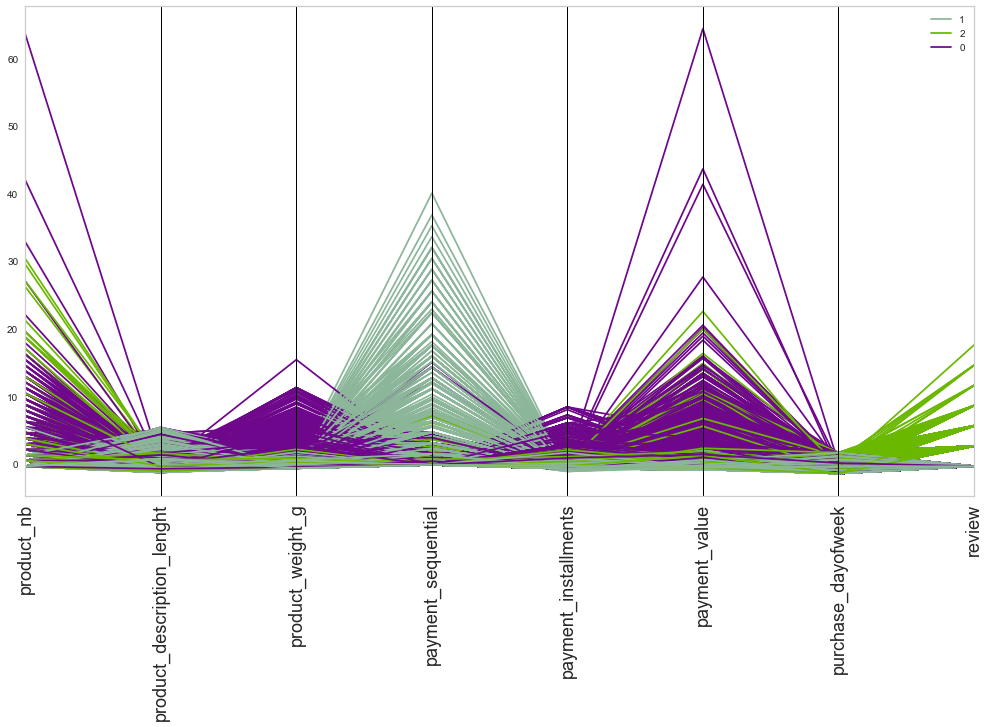

In [ ]:
# pd.plotting.parallel_coordinates

plt.figure(figsize = (17, 9))
pd.plotting.parallel_coordinates(df_clusters, 'cluster_num')
plt.xticks(fontsize = 18, rotation = 90)
plt.show()

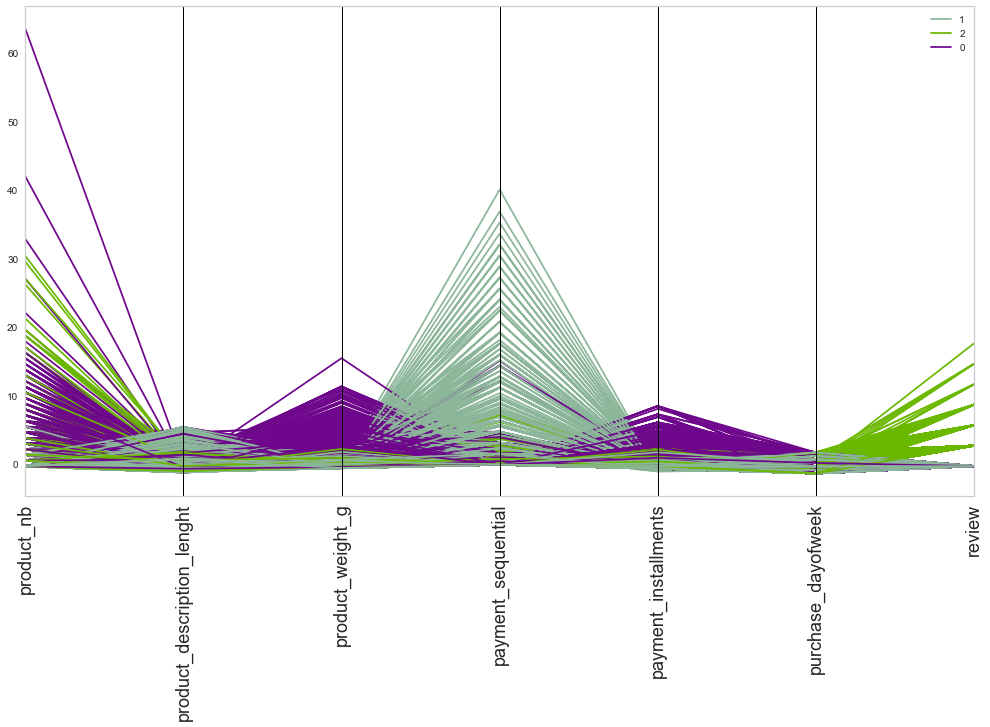

In [ ]:
# pd.plotting.parallel_coordinates

plt.figure(figsize = (17, 9))
pd.plotting.parallel_coordinates(df_clusters.drop(['payment_value'], axis = 1), 'cluster_num')
plt.xticks(fontsize = 18, rotation = 90)
plt.show()

In [ ]:
mean = df_clusters.groupby('cluster_num').mean()
mean['cluster_num'] = mean.index

In [ ]:
mean

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,purchase_dayofweek,review,cluster_num
cluster_num,,,,,,,,,
0,0.39184,0.09559,0.85855,-0.10679,1.16721,0.80723,0.02947,-0.31999,0
1,-0.16903,-0.02867,-0.26071,0.04564,-0.37426,-0.28565,-0.00680,-0.33171,1
2,0.27016,-0.01513,-0.11506,-0.07087,-0.02865,0.15310,-0.01784,2.80826,2


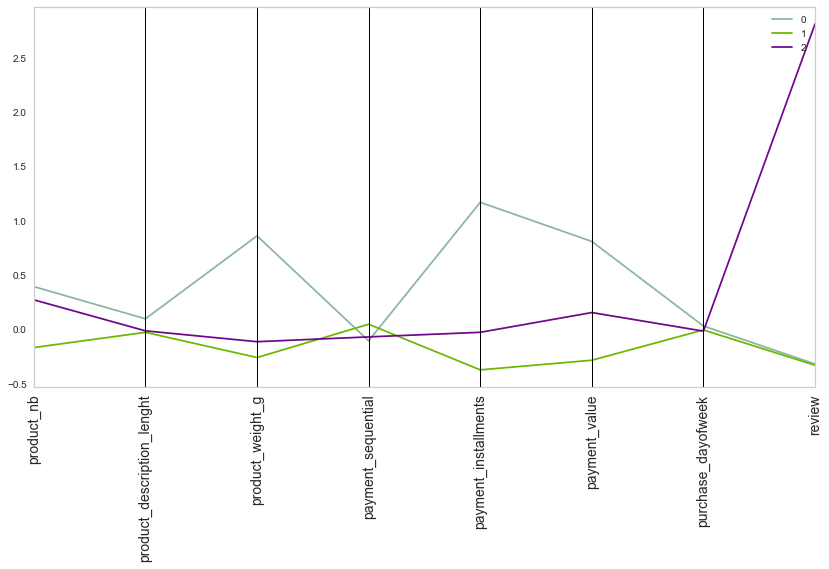

In [ ]:
# pd.plotting.parallel_coordinates

plt.figure(figsize = (14, 7))
pd.plotting.parallel_coordinates(mean, 'cluster_num')
plt.xticks(fontsize = 14, rotation = 90)
plt.show()

In [ ]:
# Vulgariser les types de clusters -> pouvoir dire 'tel type de client a tel profil' etc

In [ ]:
# autre idée de visualisation -> pairplot et colorer par cluster

# Pairplot
#plt.figure()
#sns.pairplot(df_clusters, hue = 'cluster_num', palette = 'viridis')
#plt.show()


# ne pas faire avec plus de 6 variables sinon illisible...

In [ ]:
# faire boxplots par variables par clusters pour expliquer clusters

# https://www.data-to-viz.com/graph/parallel.html


[1 2 0]


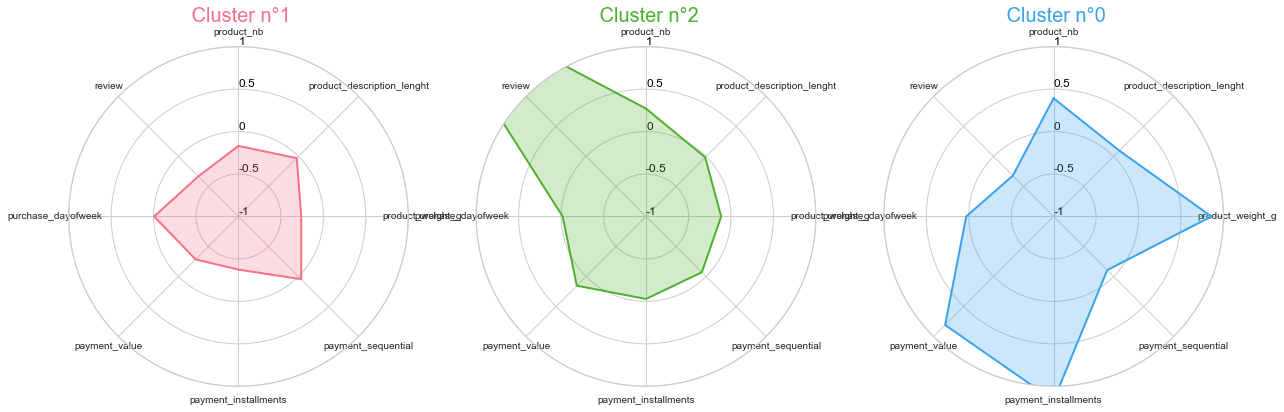

In [ ]:
####### Radar plot (wip)

clusters_customers = df_clusters['cluster_num'].unique()
print(clusters_customers)

# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(clusters_customers))
colors = {label: color for label, color in zip(clusters_customers, palette_1.as_hex())}

# Aggrégation par moyenne des valeurs par segment
df_plot = df_clusters.groupby(['cluster_num']).agg("mean")


# Noms des variables
categories = list(df_plot.columns)

# Nombre de variables
N = len(categories)

# Quel sera l'angle de chaque axe ?
# On divise un tour complet par le nombre de variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(1, figsize = (28, 28)) # un peu gros, à réduire

# Trace un radar chart pour chaque segment
for i, segment in enumerate(df_clusters['cluster_num'].unique()):
    ax = fig.add_subplot(2, 4, i + 1, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
    plt.yticks(color = "grey", size = 2)
    #values = list(df_plot_std.loc[segment].values)
    values = list(df_plot.loc[segment].values)
    values += values[:1]
    ax.plot(angles, values, colors[segment],
            'o-', linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, colors[segment], alpha = 0.25)
    plt.yticks([-1, -0.5, 0, 0.5, 1],
               ["-1", "-0.5", "0", "0.5", "1"],
               color = "black",
               size = 12)
    ax.set_title(f' Cluster n°{segment}', size = 20, color = colors[segment])
    ax.grid(True)
    plt.ylim(-1, 1)

plt.show()

In [ ]:
# garder nb de commandes et nb de produits/commandes séparés

In [ ]:
#### Cluster 1 = plus gros cluster, regroupe plus de 50% des clients

# Clients 'occasionnels' 
# -> commandent 1 fois 1 produit pas cher pas lourd, paient en une fois, ne laissent pas de review

#### CLuster 2

# Clients 'testeurs'/'influenceurs'
# clients qui dépensent un peu plus que les occasionnels
# vont commander quelques produits sans dépenser trop et laissser leur avis

#### Cluster 0

# Client 'fidèles'/'réguliers'
# achètent des produits les plus couteux et les plus volumineux - paient en plusieurs fois, avec un seul type de paiement (carte bleue) 
# dépensent le plus d'argent
# vont payer en plusieurs fois, commander des articles dans une autre ville


In [ ]:
df_clusters.columns

Index(['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value',
       'purchase_dayofweek', 'review', 'cluster_num'],
      dtype='object')

In [ ]:

# Boxplot du temps de livraison pour chaque note
sns.boxplot(x = 'review_score', y = 'purchase_month',
            data = df_clusters, hue = 'cluster_num')
plt.show()

ValueError: Could not interpret input 'review_score'

In [ ]:
# Nommer les clusters

df_clusters.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard',
                         3:'career focused'})

In [ ]:
# faire boucle pour faire les plots

# sinon, prendre les variables qui ont l'air le plus intéressantes pour expliquer les clusters

In [ ]:
# 3d-plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = np.array(labels == 0)
y = np.array(labels == 1)
z = np.array(labels == 2)

ax.scatter(df_clusters[x]['payment_value'], df_clusters[x]['purchase_hour'], df_clusters[x]['full_written_review'], color = 'red')
ax.scatter(df_clusters[y]['payment_value'], df_clusters[y]['purchase_hour'], df_clusters[y]['full_written_review'], color = 'blue')
ax.scatter(df_clusters[z]['payment_value'], df_clusters[z]['purchase_hour'], df_clusters[z]['full_written_review'], color = 'yellow')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c = 'black', s = 150, label = 'Center', alpha = 1)

In [ ]:
# 3d-plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = np.array(labels == 0)
y = np.array(labels == 1)
z = np.array(labels == 2)

ax.scatter(df_clusters[x]['full_written_review'], df_clusters[x]['order_time'], df_clusters[x]['payment_value'], color = 'red')
ax.scatter(df_clusters[y]['full_written_review'], df_clusters[y]['order_time'], df_clusters[y]['payment_value'], color = 'blue')
ax.scatter(df_clusters[z]['full_written_review'], df_clusters[z]['order_time'], df_clusters[z]['payment_value'], color = 'yellow')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c = 'black', s = 150, label = 'Center', alpha = 1)

In [ ]:
# terminer de tester les autres modèles (aglomerative)
# aller plus loin dans le feature eng -> le but est à la fin de pouvoir expliquer le comportement des clients
# faire mon acp et aller jusqu'au cercle des corrélations -> prendre les variables qui ont des grands vecteurs
# catégories de produits -> faire le mapping vers des catégories plus pertinentes (chatgpt)

In [ ]:
# faire un premier choix arbitraire et en fonction des résultats je peux identifier les variables qui sont vraiment pertinentes ou non etc

In [ ]:
# finir de tester mes différents modèles, les comparer et choisir le meilleur
# avoir une description vulgarisée du comportement des clients de chaque cluster

In [ ]:
# Cluster interpretation

# https://python.plainenglish.io/a-comprehensive-guide-to-customer-segmentation-in-python-with-kmeans-a04068f8c3c

In [ ]:
# https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering
# à lire

## Agglomerative clustering

In [ ]:
# agglomerative clustering vs kmeans

# https://datascience.stackexchange.com/questions/91182/when-should-we-choose-agglomerative-clustering-over-k-means-clustering
# https://medium.com/@namanbhandari/agglomerative-clustering-vs-k-means-clustering-766a90b37dc0
# https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019

In [ ]:
# Run sur google colab -> echec (pas assez de RAM)
# Run en local -> echec (kernel planté)

# -> # complexité algorithmique -> n cube

#-> test avec un échantillon réduit

In [ ]:
# Complexité algorithmique

# = quantité de ressources (temps, espace...) nécessaire à l'execution d'un algorithme
# calcul de la complexité d'un algorithme permet de mesurer sa performance (ah bon)

# Il existe deux types de complexité :
# - complexité spatiale : permet de quantifier l'utilisation de la mémoire
# - complexité temporelle :  permet de quantifier la vitesse d'execution

# 1 - Complexité temporelle

# L’objectif d’un calcul de complexité algorithmique temporelle est de pouvoir comparer l’efficacité d’algorithmes résolvant le même problème.
# Dans une situation donnée, cela permet donc d’établir lequel des algorithmes disponibles est le plus optimal.
# -> revient à compter le nombre d'opérations élémentaires (affectation, calcul arithmétique ou logique, comparaison...) effectuées par l'algorithme
# (on part du principe que toutes les opérations élémentaires ont le même coût de '1')

# attention -> temps peut dépendre du langage de programmation utilisé, du processeur de l'ordinateur, du compilateur employé etc...

# Plusieurs classes de complexité :
# - constante, logarithmique, linéraire, cubique, exponentielle...


In [ ]:
# Complexité algo de l'agglomerative clustering :
# https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/
# The time complexity of a naive agglomerative clustering is O(n3) because we exhaustively scan the N x N matrix dist_mat for the lowest distance in each of
# N-1 iterations. Using priority queue data structure we can reduce this complexity to O(n2logn). By using some more optimizations it can be brought down to O(n2).

In [ ]:
df.shape

In [ ]:
# Test avec un échantillon de 10% :
df_sampled = df.sample(frac = 0.1, axis = 0)

In [ ]:
# code :
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [ ]:
# articles à regarder :
# https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/
# https://medium.com/datadenys/what-is-agglomerative-clustering-and-how-to-use-it-with-python-scikit-learn-7e127ddb148c
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering_metrics.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-metrics-py

In [ ]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/3b.%20Hierarchical%20Clustering.ipynb

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity = 'euclidean',
                                      linkage = 'ward',
                                      compute_full_tree = True)

In [ ]:
# Comment définir nb de cluster optimal ?

In [ ]:
# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters = 3) # pour trouver 3 clusters
clusters_3 = hiercluster.fit_predict(df_sampled)
np.bincount(clusters_3) # count of data points in each cluster

In [ ]:
# Evaluation du clustering : silhouette score
silhouette_agglo_3 = round(silhouette_score(df_sampled, clusters_3), 2)
print('The average silhouette score is:', silhouette_agglo_3)

In [ ]:
# Read off 5 clusters:
hiercluster.set_params(n_clusters = 5)
clusters_5 = hiercluster.fit_predict(df_sampled)
np.bincount(clusters_5)

In [ ]:
# Evaluation du clustering : silhouette score
silhouette_agglo_5 = round(silhouette_score(df_sampled, clusters_5), 2)
print('The average silhouette score is:', silhouette_agglo_5)

In [ ]:
# Add cluster number to the original data
df_sampled_clustered = pd.DataFrame(df_sampled,
                                       columns = df_sampled.columns,
                                       index = df_sampled.index)
df_sampled_clustered['cluster'] = clusters_5

df_sampled_clustered.head()

In [ ]:
# Find the size of the clusters
df_sampled_clustered["cluster"].value_counts()

In [ ]:
# regarder si imbalanced ou non

In [ ]:
def plot_dendrogram(Z, names, figsize = (10, 25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize = figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [ ]:
# Show a dendrogram, just for the first smallest cluster
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
sample = df_sampled_clustered[df_sampled_clustered.cluster == 2] # prendre le cluster 2 car celui avec le moins d'échantillons donc sera plus lisible
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

In [ ]:
sample = df_sampled
Z = linkage(sample, 'ward')
names = sample.index
plot_dendrogram(Z, names, figsize = (10, 15))

In [ ]:
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize = (8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(df_sampled, method ='ward')))

In [ ]:
# résultat doit être à peu près similaire à ce qu'on option avec kmeans
# or on a du beaucoup réduire jeu de données donc trop contraignant donc pas adapté à notre situation donc on abandonne

In [ ]:
# REGARDER INFERENCE BAYESIENNE et voir si on ne peut pas faire ça ici

## DBSCAN

In [ ]:
# DBSCAN

# https://datascientest.com/machine-learning-clustering-dbscan#:~:text=Le%20DBSCAN%20est%20un%20algorithme%20simple%20qui%20d%C3%A9finit%20des%20clusters,estimation%20de%20la%20densit%C3%A9%20locale.
# Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale

# https://www.reneshbedre.com/blog/dbscan-python.html

In [ ]:
# 1) calculer epsilon et min_samples

In [ ]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors = 5).fit(df_sampled)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df_sampled)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [ ]:
!pip install kneed
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0,
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

In [ ]:
kneedle.plot_knee()
plt.show()

In [ ]:
# utiliser cet optimum pour le dbscan clustering

eps = kneedle.knee_y

In [ ]:
df_sampled.columns

In [ ]:
# min_samples = 2 * number of dimensions

min_samples = 2 * df_sampled.shape[1]

# fixer min_samples à 100 -> sinon ne fait pas sens (on veut au moins 100 clients par cluster)
# essayer avec un min_samples à 10 et faire varier epsilon
# le but étant de montrer que pas adapté

In [ ]:
# ATTENTION -> les clusters et les num de clusters sont dans le df ?????

# c'est quoi level_0 ???

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps = eps, min_samples = min_samples).fit(df_sampled)

# get cluster labels
labels = db.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
# check unique clusters
set(labels) # -1 value represents noisy points could not assigned to any cluster

In [ ]:
# Get each cluster size
from collections import Counter
Counter(labels)

In [ ]:
y_pred = DBSCAN(eps = eps, min_samples = min_samples).fit_predict(df_sampled)

In [ ]:
# Evaluation du clustering : silhouette score
silhouette_dbscan = round(silhouette_score(df_sampled, y_pred), 2)
print('The average silhouette score is:', silhouette_dbscan)

In [ ]:
from sklearn import metrics
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [ ]:
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['product_category'],
            c = y_pred)
plt.show()

In [ ]:
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['product_category'],
            c = y_pred,
            cmap = plt.get_cmap('jet'))
plt.show()

In [ ]:
plt.figure()
p = sns.scatterplot(data = df_sampled,
                    x = 'purchase_day',
                    y = 'product_category',
                    hue = labels,
                    legend = 'full',
                    palette = 'deep')
sns.move_legend(p,
                'upper right',
                bbox_to_anchor = (1.17, 1.),
                title = 'Clusters')
plt.show()

## Spectral clustering

In [ ]:
# https://www.kaggle.com/code/vipulgandhi/spectral-clustering-detailed-explanation

In spectral clustering, data points are treated as nodes of a graph. Thus, spectral clustering is a graph partitioning problem. The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. No assumption is made about the shape/form of the clusters. The goal of spectral clustering is to cluster data that is connected but not necessarily compact or clustered within convex boundaries.

Spectral Clustering vs. Kmeans
Compactness — Points that lie close to each other fall in the same cluster and are compact around the cluster center. The closeness can be measured by the distance between the observations. E.g.: K-Means Clustering
Connectivity — Points that are connected or immediately next to each other are put in the same cluster. Even if the distance between 2 points is less, if they are not connected, they are not clustered together. Spectral Clustering is a technique that follows this approach.



In [ ]:
# https://www.geeksforgeeks.org/ml-spectral-clustering/
#### à lire

In [ ]:
# souvent utilisé après une ACP comme ça les données sont visualisées en 2D (en gardant 2 composantes uniquement) donc plus facile d'évaluer perf du clustering
# (comme pour tous les algo en fait...)

In [ ]:
# complexité algorithmique : O(n3)
# -> utiliser le df_sampled

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
# Comment définir nb de cluster optimal ?

In [ ]:
%%time
# affinity matrix avec kernel Gaussien
# -> 'affinity' = 'rbf'

# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf')

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(df_sampled)

In [ ]:
# Evaluation du clustering : silhouette score
silhouette_spectral_rbf = round(silhouette_score(df_sampled, labels_rbf), 2)
print('The average silhouette score is:', silhouette_spectral_rbf)

In [ ]:
# Visualizing the clustering
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['purchase_dayofweek'],
            c = SpectralClustering(n_clusters = 4, affinity = 'rbf').fit_predict(df_sampled),
            cmap = plt.cm.winter)
plt.show()

In [ ]:
%%time
# -> affinity = ‘nearest_neighbors’

# Building the clustering model
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors')

# Training the model and Storing the predicted cluster labels
labels_nn = spectral_model_nn.fit_predict(df_sampled)

In [ ]:
# Evaluation du clustering : silhouette score
silhouette_spectral_nn = round(silhouette_score(df_sampled, labels_nn), 2)
print('The average silhouette score is:', silhouette_spectral_nn)

In [ ]:
# Visualizing the clustering
plt.figure()
plt.scatter(df_sampled['payment_value'],
            df_sampled['purchase_dayofweek'],
            c = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors').fit_predict(df_sampled),
            cmap = plt.cm.winter)
plt.show()

In [ ]:
# Evaluer performances (sur dataset avant sampling ? )

# List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(df_std_reduit, labels_rbf))
s_scores.append(silhouette_score(df_std_reduit, labels_nn))

print(s_scores)

In [ ]:
# Comparer performance des différents algo

# https://saturncloud.io/blog/performance-analysis-of-clustering-algorithms/#:~:text=The%20adjusted%20Rand%20index%20(ARI,value%20indicates%20better%20clustering%20performance.
# https://stats.stackexchange.com/questions/95782/what-are-the-most-common-metrics-for-comparing-two-clustering-algorithms-especi

# ARI Score

In [ ]:
# tester stabilité de la segmentation client dans le temps et voir à quel moment les clients changent de cluster
# pour ça, on réitère les étapes précedantes sur des périodes décalées dans le temps de 30j, 60j, 90j...

In [17]:
df_clusters.columns

Index(['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review',
       'cluster_num'],
      dtype='object')

In [18]:
# concat avec date
df_ari = pd.concat([df_clusters, df_final['Date_achat']], axis = 1)
df_ari

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
0,0.46681,-0.70040,0.05134,-0.13044,-0.70900,-0.09601,-0.33171,2,2017-11-30
1,-0.36326,0.29287,-0.29139,-0.13044,-0.70900,-0.55278,-0.33171,2,2017-10-29
2,-0.36326,-0.37099,-0.56494,-0.13044,0.08583,-0.65354,2.65422,1,2018-05-07
3,-0.36326,1.18867,-0.23414,-0.13044,2.07291,-0.06261,-0.33171,0,2017-08-27
4,-0.36326,2.93488,-0.60470,-0.13044,-0.70900,-0.72670,-0.33171,2,2017-01-05
...,...,...,...,...,...,...,...,...,...
87094,2.95703,-0.31721,0.30977,-0.13044,-0.31159,1.26897,5.64015,1,2018-04-30
87095,-0.36326,-1.17267,0.46881,-0.13044,-0.31159,-0.60127,-0.33171,2,2017-12-15
87096,-0.36326,-1.07183,-0.38602,-0.13044,-0.31159,-0.57028,2.65422,1,2018-05-07
87097,-0.36326,-0.72057,-0.45719,-0.13044,0.88066,1.40077,-0.33171,0,2017-06-15


In [20]:
# order by date et reset index

df_ari.sort_values(['Date_achat'], inplace = True)
df_ari

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
78283,-0.36326,-0.85670,0.07122,-0.13044,0.08583,-0.38400,-0.33171,2,2016-10-03
19745,0.46681,0.86346,-0.55500,-0.13044,-0.11288,0.69035,-0.33171,2,2016-10-03
28527,-0.36326,-0.40292,-0.48542,-0.13044,-0.70900,-0.63486,-0.33171,2,2016-10-03
84080,-0.36326,-0.71721,-0.57488,-0.13044,-0.70900,-0.62684,-0.33171,2,2016-10-04
51685,-0.36326,-0.20292,0.34953,1.47712,-0.70900,-0.46711,-0.33171,2,2016-10-04
...,...,...,...,...,...,...,...,...,...
77545,-0.36326,-0.55250,-0.46554,-0.13044,-0.70900,-0.66250,-0.33171,2,2018-08-29
22291,0.46681,1.49791,-0.54506,-0.13044,-0.31159,1.52639,-0.33171,2,2018-08-29
74572,-0.36326,-0.21637,-0.52916,-0.13044,-0.70900,0.02159,-0.33171,2,2018-08-29
8187,1.29688,1.49791,-0.54506,-0.13044,-0.31159,1.52639,-0.33171,0,2018-08-29


In [21]:
df_ari.reset_index(drop = True, inplace = True)

In [22]:
# définir timedelta

# premier date dispo = 03/10/2016
# dernière date dispo = 29/08/2018

# quasiment 2ans de données
# timedelta = prendre 6 mois glissants ? 180j

# écart entre les dates et les lignes n'est pas constant donc passer automatiquement pas les dates

date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)
print(date_fin)

filter_date = (df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin) 
df_date = df_ari[filter_date].copy()
df_date

,product_nb,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
3,-0.36326,-0.71721,-0.57488,-0.13044,-0.70900,-0.62684,-0.33171,2,2016-10-04
4,-0.36326,-0.20292,0.34953,1.47712,-0.70900,-0.46711,-0.33171,2,2016-10-04
5,-0.36326,-0.95922,2.37728,-0.13044,1.27808,-0.26328,-0.33171,0,2016-10-04
6,-0.36326,-0.76427,-0.06794,-0.13044,0.88066,-0.04940,-0.33171,2,2016-10-04
7,-0.36326,-0.25670,-0.60470,-0.13044,-0.31159,-0.46659,-0.33171,2,2016-10-04
...,...,...,...,...,...,...,...,...,...
4802,-0.36326,0.65422,-0.56494,-0.13044,-0.70900,-0.69727,-0.33171,2,2017-03-31
4803,-0.36326,-1.03989,-0.60470,-0.13044,-0.70900,-0.62608,-0.33171,2,2017-03-31
4804,-0.36326,-0.51721,2.93392,1.47712,-0.70900,-0.47084,-0.33171,2,2017-03-31
4805,-0.36326,-0.86006,-0.56494,-0.13044,-0.70900,-0.67444,-0.33171,2,2017-03-31


In [23]:
df_date.columns

Index(['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review',
       'cluster_num', 'Date_achat'],
      dtype='object')

In [ ]:
# surtout ajout de nouveaux clients - actuels clients pas susceptibles de changer de comportement
# prendre intervalle de base suffisamment grand et glisser dans le temps pour voir impact de l'arrivée de nouveaux clients sur nos clusters

# sujet sur l'integration des nouveaux clients dans le calcul du score ARI
# calculer score ari par rapport à t0

In [24]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

data_cluster = df_date[['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

#data_cluster['paye_par_commande'] = QuantileTransformer(n_quantiles = 5).fit_transform(np.array(data_cluster['paye_par_commande']).reshape(-1, 1))
#data_cluster['date_commande'] = QuantileTransformer(n_quantiles = 5).fit_transform(np.array(data_cluster['date_commande']).reshape(-1, 1))
#data_cluster['delai_jours'] = QuantileTransformer(n_quantiles = 5).fit_transform(np.array(data_cluster['delai_jours']).reshape(-1, 1))

X_std = MinMaxScaler().fit_transform(data_cluster)

dict_km = {}

for i in range(1, 51):
    km = KMeans(n_clusters = 3)
    km.fit(X_std)
    dict_km[i] = km.labels_
    
stab_clust = []
for cle in dict_km.keys():
    for i in range(cle+1,51):
        ari = adjusted_rand_score(dict_km[cle], dict_km[i])
        stab_clust.append(ari)
#        print(cle,i, ari)

print('ARI moyen : ', np.array(stab_clust).mean())

ARI moyen :  0.997835135150188


In [26]:
# entrainement du premier modele
date_fin = pd.to_datetime('2018-05-31')
date_debut = date_fin - pd.Timedelta(days = 180)

filter_date = (df_ari['Date_achat'] > date_debut) &  (df_ari['Date_achat'] < date_fin) 
df_trim = df_ari[filter_date].copy()

data_cluster = df_trim[['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

X_std = MinMaxScaler().fit_transform(data_cluster)

km = KMeans(n_clusters = 3)
km.fit(X_std)
data_cluster['cluster'] = km.labels_

In [27]:
# creation du jeu de test et premiere prediction
date_debut = pd.to_datetime('2018-06-01')
date_fin = pd.to_datetime('2018-06-30')

filter_date = (df_ari['Date_achat']>date_debut) &  (df_ari['Date_achat']<date_fin) 
df_trim = df_ari[filter_date].copy()

data_cluster = df_trim[['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

X_std = MinMaxScaler().fit_transform(data_cluster)
data_cluster['cluster'] = km.predict(X_std)

1 2018-01-31 00:00:00 2018-07-30 00:00:00 0.9811268473693705
2 2018-01-01 00:00:00 2018-06-30 00:00:00 0.9842093569449427
3 2017-12-02 00:00:00 2018-05-31 00:00:00 0.9986363668065453
4 2017-11-02 00:00:00 2018-05-01 00:00:00 0.9844652251204309
5 2017-10-03 00:00:00 2018-04-01 00:00:00 0.828549560830173
6 2017-09-03 00:00:00 2018-03-02 00:00:00 0.8230958587777762
7 2017-08-04 00:00:00 2018-01-31 00:00:00 0.8145434818019028
8 2017-07-05 00:00:00 2018-01-01 00:00:00 0.8105095613406966
9 2017-06-05 00:00:00 2017-12-02 00:00:00 0.8263020418590127
10 2017-05-06 00:00:00 2017-11-02 00:00:00 0.958437131189865
11 2017-04-06 00:00:00 2017-10-03 00:00:00 0.9585851283169442
12 2017-03-07 00:00:00 2017-09-03 00:00:00 0.8946998864656721
13 2017-02-05 00:00:00 2017-08-04 00:00:00 0.8716528619180156
14 2017-01-06 00:00:00 2017-07-05 00:00:00 0.874941238200121


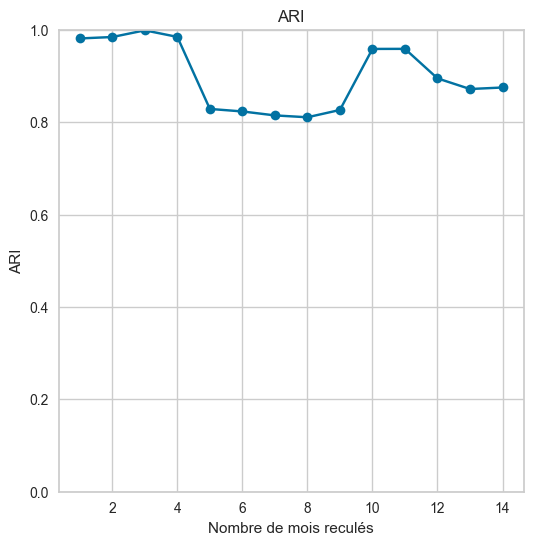

In [28]:
from sklearn.metrics.cluster import adjusted_rand_score

date_fin = pd.to_datetime('2018-08-29')
date_debut = date_fin - pd.Timedelta(days = 180)

ARI = []
for i in range(1, 15):
    date_new = date_debut - pd.Timedelta(days = 30*i)
    date_new_fin = date_new + pd.Timedelta(days = 180)

    filter_date = (df_ari['Date_achat'] > date_new) &  (df_ari['Date_achat'] < date_new_fin) 
    df_trim = df_ari[filter_date].copy()

    data_cluster_range = df_trim[['product_nb', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

    #data_cluster_range.paye_par_commande = np.log1p(data_cluster_range.paye_par_commande)
    #data_cluster_range.delai_jours = np.log1p(data_cluster_range.delai_jours)

    #data_cluster_range['paye_par_commande'] = QuantileTransformer(n_quantiles=5).fit_transform(np.array(data_cluster_range['paye_par_commande']).reshape(-1, 1))
    #data_cluster_range['date_commande'] = QuantileTransformer(n_quantiles=5).fit_transform(np.array(data_cluster_range['date_commande']).reshape(-1, 1))
    #data_cluster_range['delai_jours'] = QuantileTransformer(n_quantiles=5).fit_transform(np.array(data_cluster_range['delai_jours']).reshape(-1, 1))

    X_std_range = MinMaxScaler().fit_transform(data_cluster_range)
   
    km_range = KMeans(n_clusters = 3)
    km_range.fit(X_std_range)
    
    data_cluster['cluster_predit'] = km_range.predict(X_std)


    sc_ari = adjusted_rand_score(data_cluster['cluster_predit'], data_cluster['cluster'])
    print(i, date_new, date_new_fin, sc_ari)
    ARI.append(sc_ari)
    
plt.figure(figsize=(6,6))
plt.plot(range(1, 15), ARI, marker = 'o')
plt.title('ARI')
plt.xlabel('Nombre de mois reculés')
plt.ylabel('ARI')
plt.ylim((0,1))
#plt.savefig('P2_14_ARI_maintenance.jpg')
plt.show()    

In [ ]:
# axe de reflexion (mais à ne pas faire ici) -> mettre à jour la base client au fur et à mesure de l'avancée dans le temps pour les clients qui font plusieurs commandes

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
# bien figer le random state et juste itérer dans le temps
# ne pas itérer en faisant plusieurs clustering sur le même temps 

In [ ]:
%%time

# Number of K-Means runs for each snapshot
n_runs = 10

# Number of clusters you want to try
n_clusters = 5  # Change this to the number of clusters you used in your K-Means

ari_scores = []

# A MODIFIER - comparer avec t0 et non avec le jour précedent
# peut etre interessant dans d'autres situations mais pas dans la notre
# eventuellement à garder pour voir l'arrivée de nouveaux clients

for i in range(1, len(data_snapshots)):
    previous_data = data_snapshots[i - 1]
    current_data = data_snapshots[i]
    previous_labels = true_labels_snapshots[i - 1]
    current_labels = true_labels_snapshots[i]

    ari_snapshot = []

    for _ in range(n_runs):
        kmeans = KMeans(n_clusters = min(n_clusters, len(previous_data)), random_state = 0)
        previous_labels_pred = kmeans.fit_predict(previous_data)
        current_labels_pred = kmeans.predict(current_data)

        ari = adjusted_rand_score(current_labels, current_labels_pred)
        ari_snapshot.append(ari)

    ari_scores.append(ari_snapshot)

# Calculate the mean and standard deviation of ARI scores for each snapshot
mean_ari = np.mean(ari_scores, axis = 1)
std_ari = np.std(ari_scores, axis = 1)

for i, (mean, std) in enumerate(zip(mean_ari, std_ari)):
    print(f"Snapshot {i + 1} - Mean ARI: {mean}, Standard Deviation of ARI: {std}")

In [ ]:
# Create a list of time points or labels for the x-axis (e.g., snapshot dates)
time_points = range(1, len(ari_scores) + 1)

# Plot the ARI scores over time
plt.figure(figsize = (10, 6))
plt.plot(time_points, ari_scores, marker = 'o', linestyle = '-')
plt.xlabel('Snapshot Time')
plt.ylabel('ARI Score')
plt.title('Cluster Stability Over Time')
plt.grid(True)
plt.tight_layout()

# Show the plot or save it to a file
plt.show()

In [ ]:
# The higher the ARI value, the closer the two clusterings are to each other. 
# It ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 
# 0 indicates a random agreement and -1 indicates that the two clusterings are completely different

In [ ]:
# Ressources intéressantes : 

# https://amueller.github.io/aml/04-model-evaluation/17-cluster-evaluation.html ###### meh
# https://github.com/FlorentF9/skstab ### non - module python pour évaluer stabilité des clusters mais pas dans le temps
# https://reval.readthedocs.io/en/latest/ ### meh
# https://www.kaggle.com/code/hamadizarrouk/segmentation-des-clients-d-un-site-e-commerce-nb2#Stabilit%C3%A9-temporelle-de-la-segmentation
